In [1]:
import struct
import pandas as pd
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)

In [3]:
log = '../flight_day_2/flight_16.txt'
#log = '../flight_day_2/test_flight_x.txt'
#log = 'flight_logs/h_flight_2.log'

In [4]:
log_b = None
with open(log, 'r') as f:
    log_str = f.read()

log_str_formatted = log_str.replace('\r\n', ' ')
log_str_formatted = log_str_formatted.replace('\n', ' ')
log_str_formatted = log_str_formatted.replace('  ', ' ')
log_str_formatted = log_str_formatted.strip()

In [5]:
# with open('test_log', 'w') as log_file:
#     log_file.write(log_str_formatted)

In [6]:
#log_b[26400:26500]

In [7]:
log_b = bytes.fromhex(log_str_formatted)

In [8]:
print(log_b[:20])

b'\x04\x00\x00\x00\xaea\x00\x00\xb0~\x01\x00k\x05\x00\x00\x05\x00\x00\x00'


In [9]:
imu = []
baro = []
flight_info = []
flight_state = []
covariance_info = []
sensor_info = []

In [10]:
i = 0
last_ts = 0
while i < len(log_b):
    t = struct.unpack('<L', log_b[i:i+4])[0]
    i += 4
    if t in [1, 2, 3]:
        ts, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z = struct.unpack('<Lhhhhhh', log_b[i: i+16])
        #print(f"{ts} IMU {t-1}: Gx: {gyro_x}, Gy: {gyro_y}, Gz: {gyro_z}, Ax: {acc_x}, Ay: {acc_y}, Az: {acc_z}")
        imu.append({'ts': ts,
                    'id': f'IMU{t - 1}',
                    'Gx': gyro_x,
                    'Gy': gyro_y,
                    'Gz': gyro_z,
                    'Ax': acc_x,
                    'Ay': acc_y,
                    'Az': acc_z})
        #print(imu_data)
        i += 4 + 6 + 6 #ts + 6 x int16
    elif t in [4, 5, 6]:
        ts, pressure, temperature = struct.unpack('<LLL', log_b[i: i+12])
        #print(f"{ts} BARO {t-4}: P: {pressure}, T: {temperature}")
        baro.append({'ts': ts,
                     'id': f'BARO{t - 4}',
                     'T': temperature,
                     'P': pressure})
        #print(baro_data)
        i += 4 + 4 + 4
    elif t == 7:
        ts, height, velocity, acceleration, altitude_agl = struct.unpack('<Lffff', log_b[i: i+20])
        #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
        flight_info.append({'ts': ts,
                            'height': height,
                            'velocity': velocity,
                            'acceleration': acceleration,
                            'altitude_agl': altitude_agl})
        #print(flight_info_data)
        i += 4 + 4 + 4 + 4 + 4
    elif t == 8:
        #print("FLIGHT_STATE")
        #ts, state = struct.unpack('<LB', log_b[i: i+5])
        ts, state = struct.unpack('<LL', log_b[i: i+8])
        flight_state.append({'ts': ts, 'state': state})
        #print(f"{ts} FLIGHT STATE: State: {state}")
        i += 4 + 4
    elif t == 9:
        ts, height_cov, velocity_cov = struct.unpack('<Lff', log_b[i: i+12])
        #print(f"{ts} COVARIANCE_INFO: Height cov: {height_cov}, Velocity cov: {velocity_cov}")
        covariance_info.append({'ts': ts,
                                'height_cov': height_cov,
                                'velocity_cov': velocity_cov})
        #print(flight_info_data)
        i += 4 + 4 + 4
    elif t == 10:
        #print(f"Sensor info found at {i}")
        ts, imu_0, imu_1, imu_2, baro_0, baro_1, baro_2 = struct.unpack('<LBBBBBB', log_b[i: i+10])
        sensor_info.append({'ts': ts,
                                'imu_0': imu_0,
                                'imu_1': imu_1,
                                'imu_2': imu_2,
                                'baro_0': baro_0, 'baro_1': baro_1, 'baro_2': baro_2})
        i += 4 + 6 + 2 # +2 is because of the padding
    else:
        print(f"ERROR at {i}")
        break
    last_ts = ts

ERROR at 541592


In [11]:
imu_df = pd.DataFrame(imu)

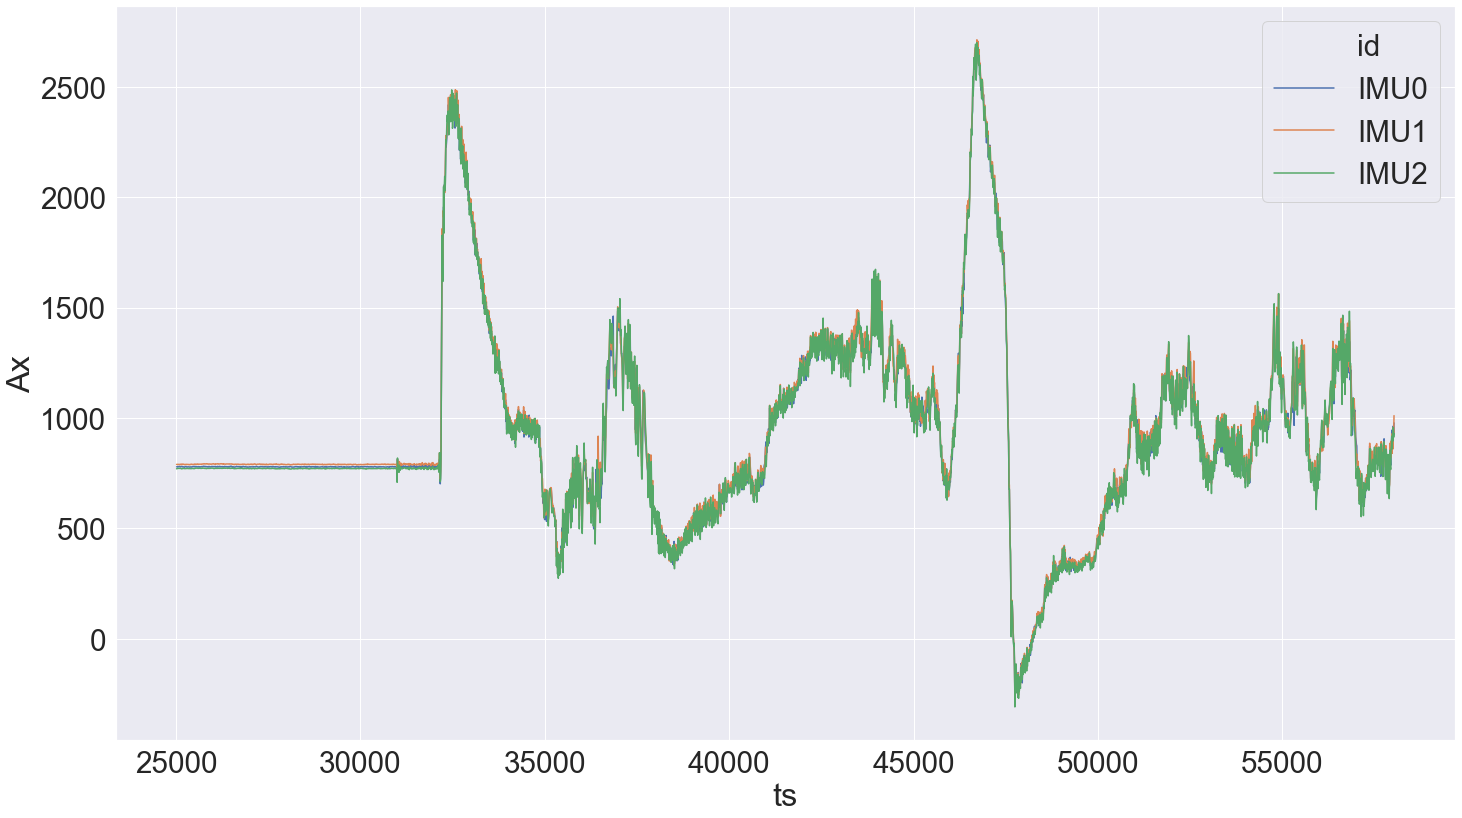

In [12]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Ax', hue = 'id')
#ax.set_ylim(-10, 6000)
#ax.set_xlim(45000, 48000)

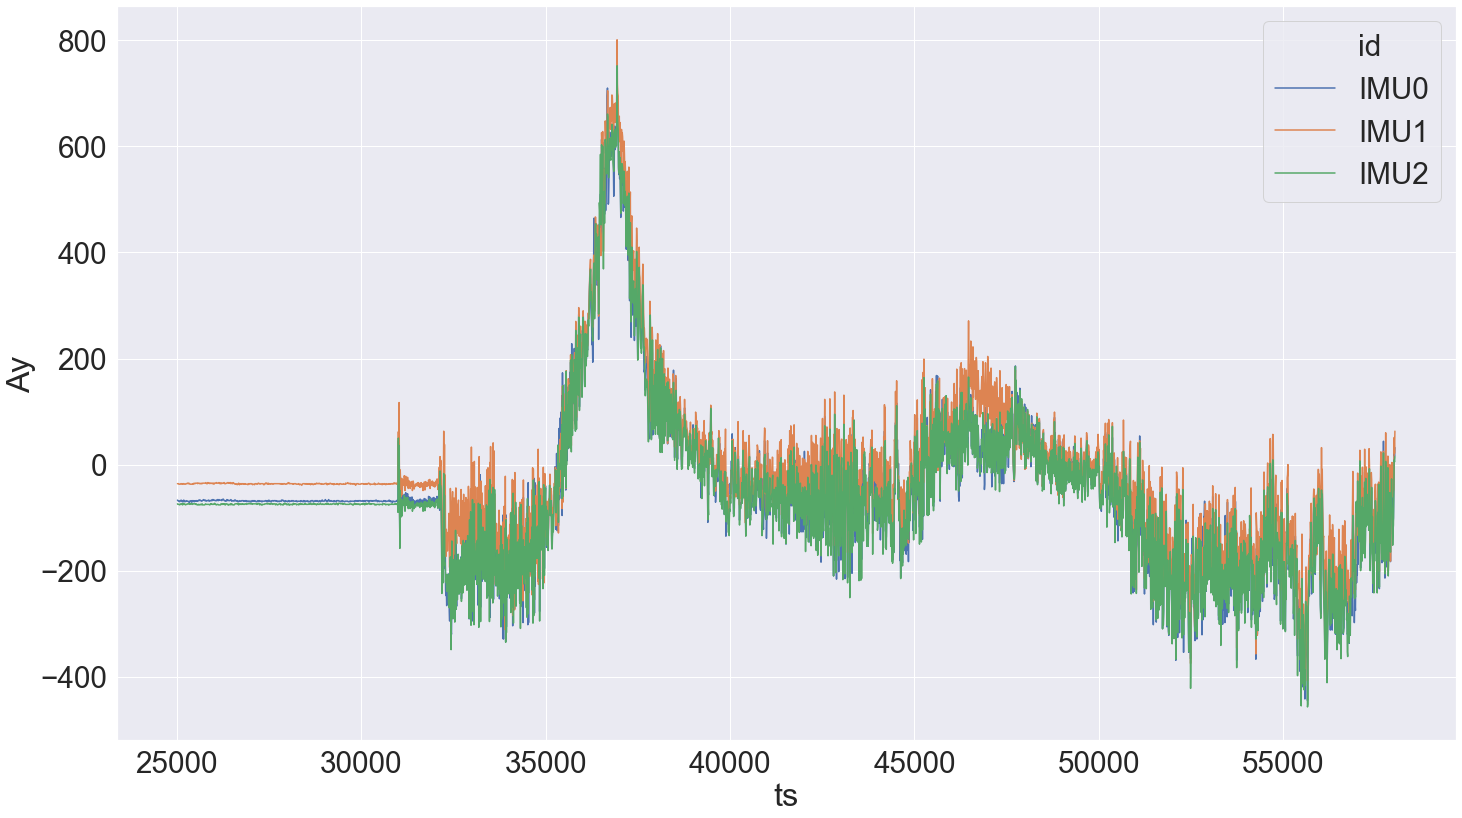

In [13]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Ay', hue = 'id')

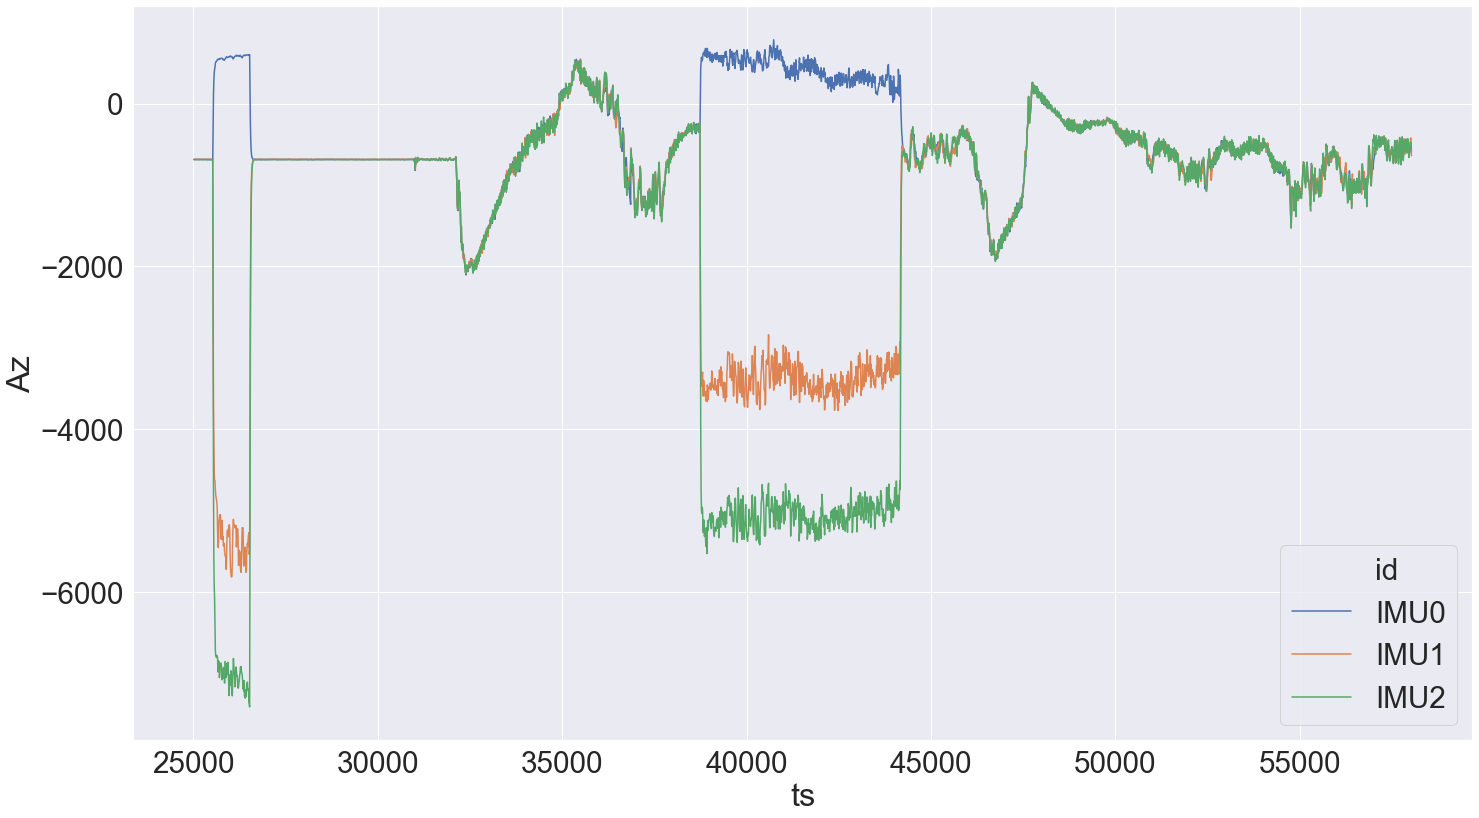

In [14]:

ax = sns.lineplot(data = imu_df, x = 'ts', y = 'Az', hue = 'id')

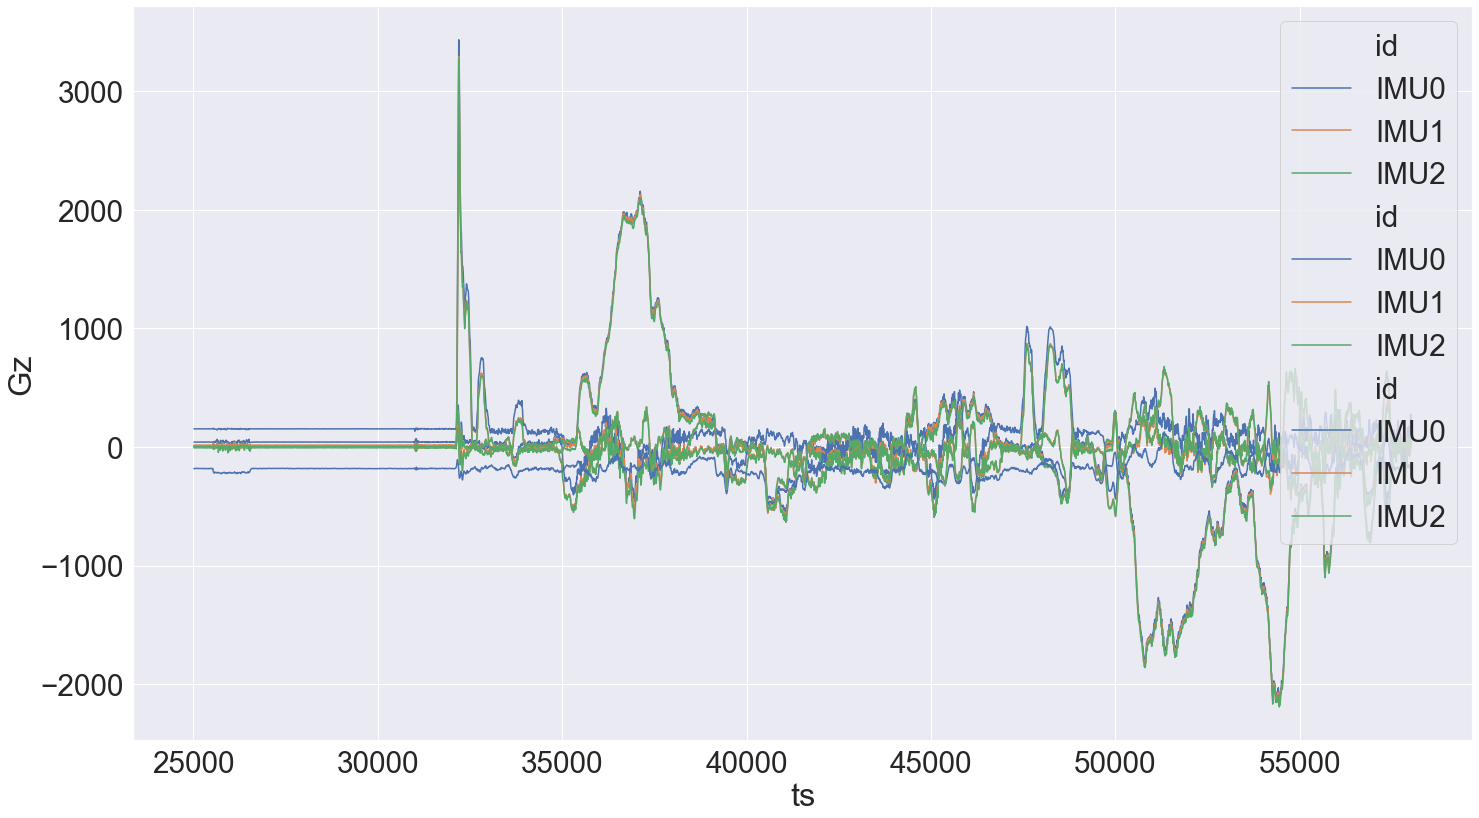

In [15]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Gx', hue = 'id')
sns.lineplot(data = imu_df, x = 'ts', y = 'Gy', hue = 'id')
sns.lineplot(data = imu_df, x = 'ts', y = 'Gz', hue = 'id')

In [16]:
flight_state

[{'ts': 25520, 'state': 2},
 {'ts': 25629, 'state': 3},
 {'ts': 35210, 'state': 5},
 {'ts': 38730, 'state': 9},
 {'ts': 43170, 'state': 10}]

In [17]:
imu_df

,ts,id,Gx,Gy,Gz,Ax,Ay,Az
0,25017,IMU0,42,153,-183,779,-67,-686
1,25017,IMU1,12,15,-2,790,-36,-683
2,25017,IMU2,-7,2,3,770,-74,-687
3,25027,IMU0,42,153,-181,779,-68,-687
4,25027,IMU1,12,15,-2,790,-36,-686
...,...,...,...,...,...,...,...,...
9901,58017,IMU1,23,6,25,930,21,-469
9902,58017,IMU2,9,32,31,913,5,-505
9903,58027,IMU0,43,181,-156,978,32,-591
9904,58027,IMU1,2,1,39,1011,63,-640


In [18]:
flight_info_df = pd.DataFrame(flight_info)

In [19]:
flight_info_df

,ts,height,velocity,acceleration,altitude_agl
0,25007,232.459000,-45.803001,-16.353195,280.232117
1,25017,232.563995,-45.917000,-16.353195,281.958069
2,25027,232.669006,-44.029999,-16.381935,281.958069
3,25037,232.746002,-44.126999,-16.381935,276.695984
4,25047,232.828003,-44.227001,-16.381935,278.178253
...,...,...,...,...,...
3297,57977,3.903000,-3.194000,1.611912,7.099249
3298,57987,3.897000,-3.206000,1.020039,7.099249
3299,57997,3.866000,-3.215000,2.254159,5.388713
3300,58007,3.841000,-3.223000,1.901554,8.893737


In [20]:
covariance_df = pd.DataFrame(covariance_info)

In [21]:
#lower_bound = flight_info_df.height + 3*(covariance_df.height_cov)**0.5]
flight_info_df['lower_bound'] = flight_info_df.height + 3*(covariance_df.height_cov)**0.5
flight_info_df['upper_bound'] = flight_info_df.height - 3*(covariance_df.height_cov)**0.5

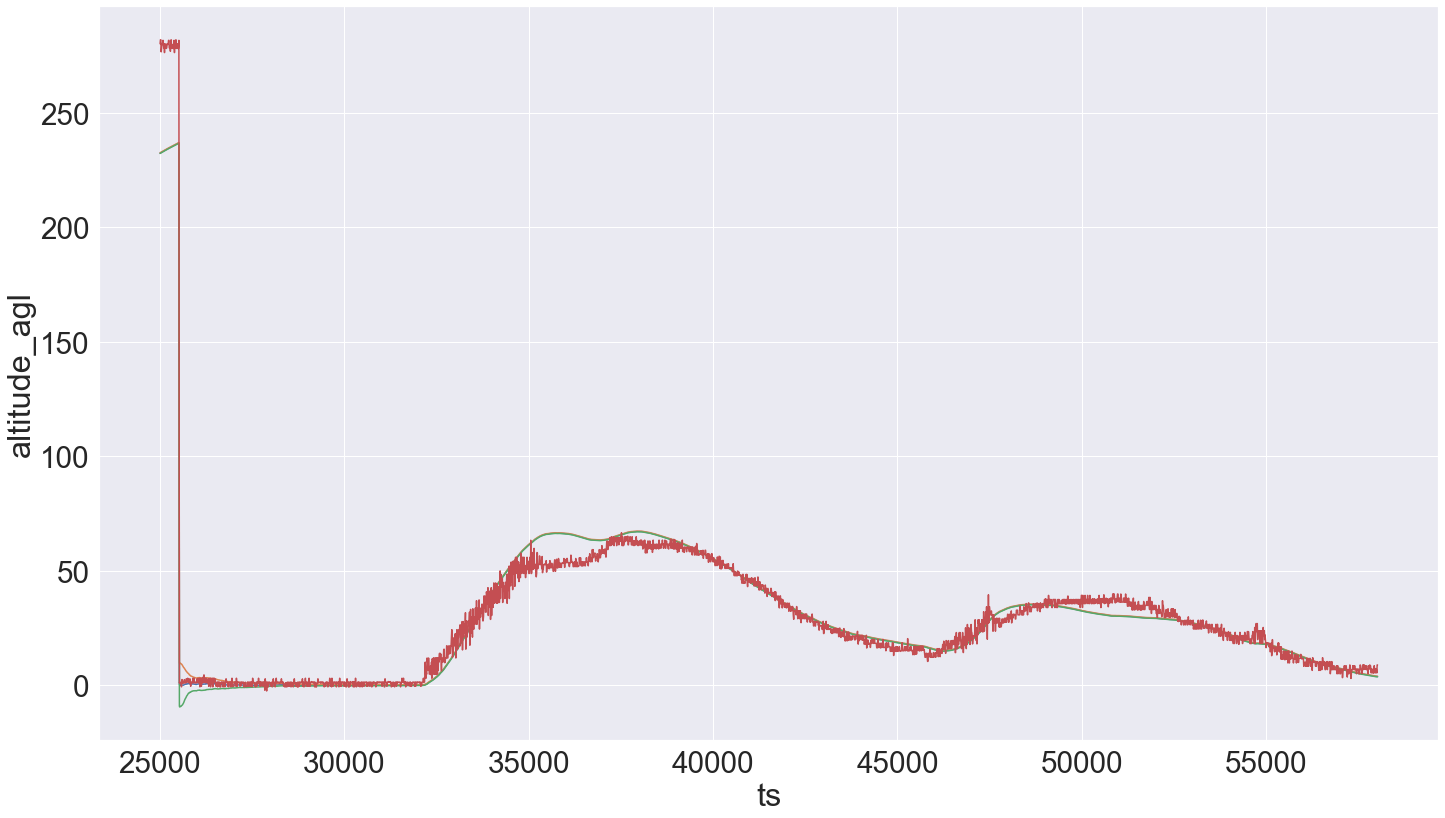

In [22]:
sns.lineplot(data = flight_info_df, x = 'ts', y = 'height')
sns.lineplot(data = flight_info_df, x = 'ts', y = 'lower_bound')
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'upper_bound')
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'altitude_agl')
#ax.set_ylim(-100, 200)
#ax.set_xlim(30000,60000)

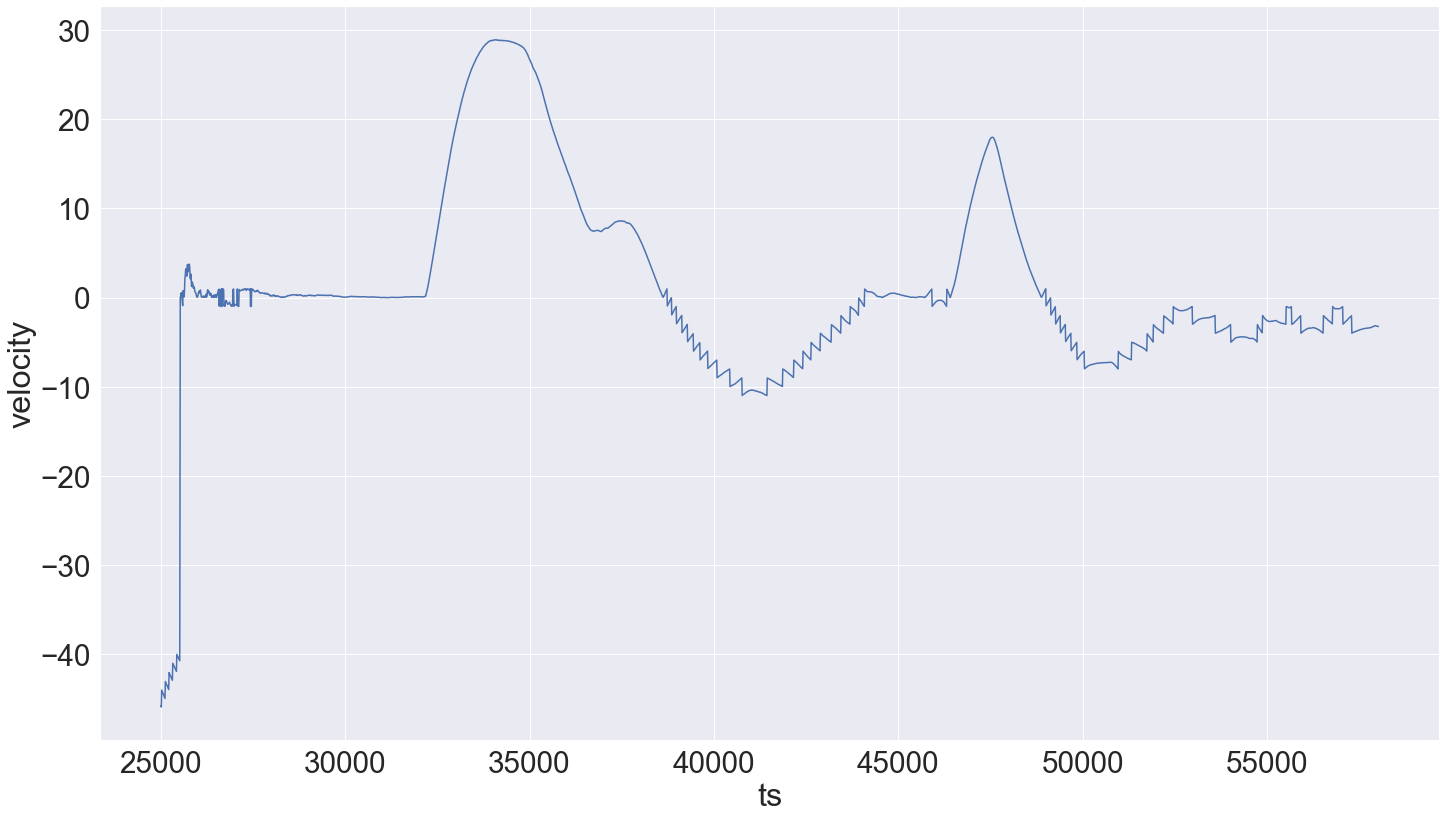

In [23]:
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'velocity')
#ax.set_ylim(-5)
#ax.set_xlim(38000)

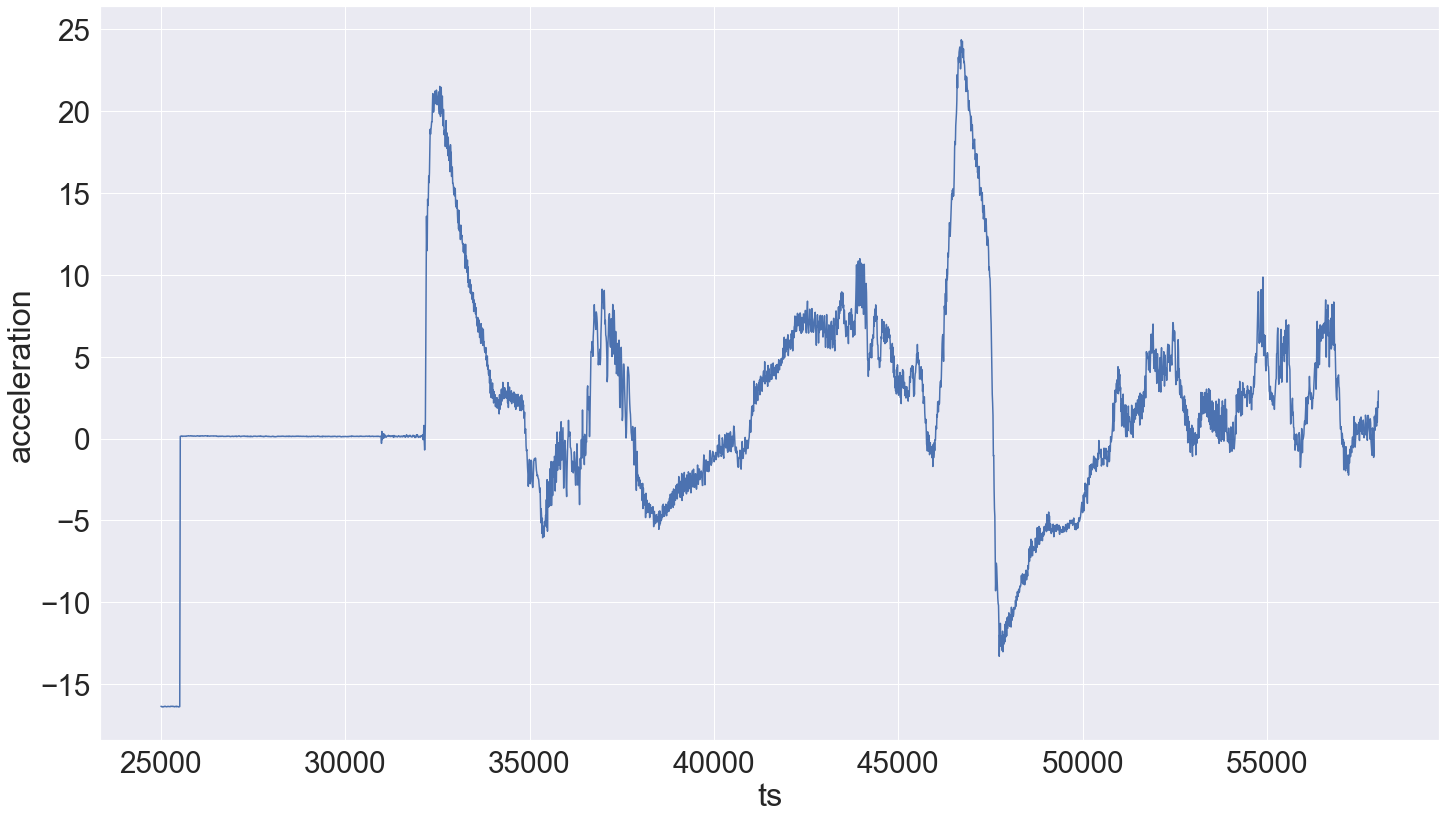

In [24]:
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'acceleration')
#ax.set_ylim(-5)
#ax.set_xlim(38000)

In [25]:
baro_df = pd.DataFrame(baro[:-1])

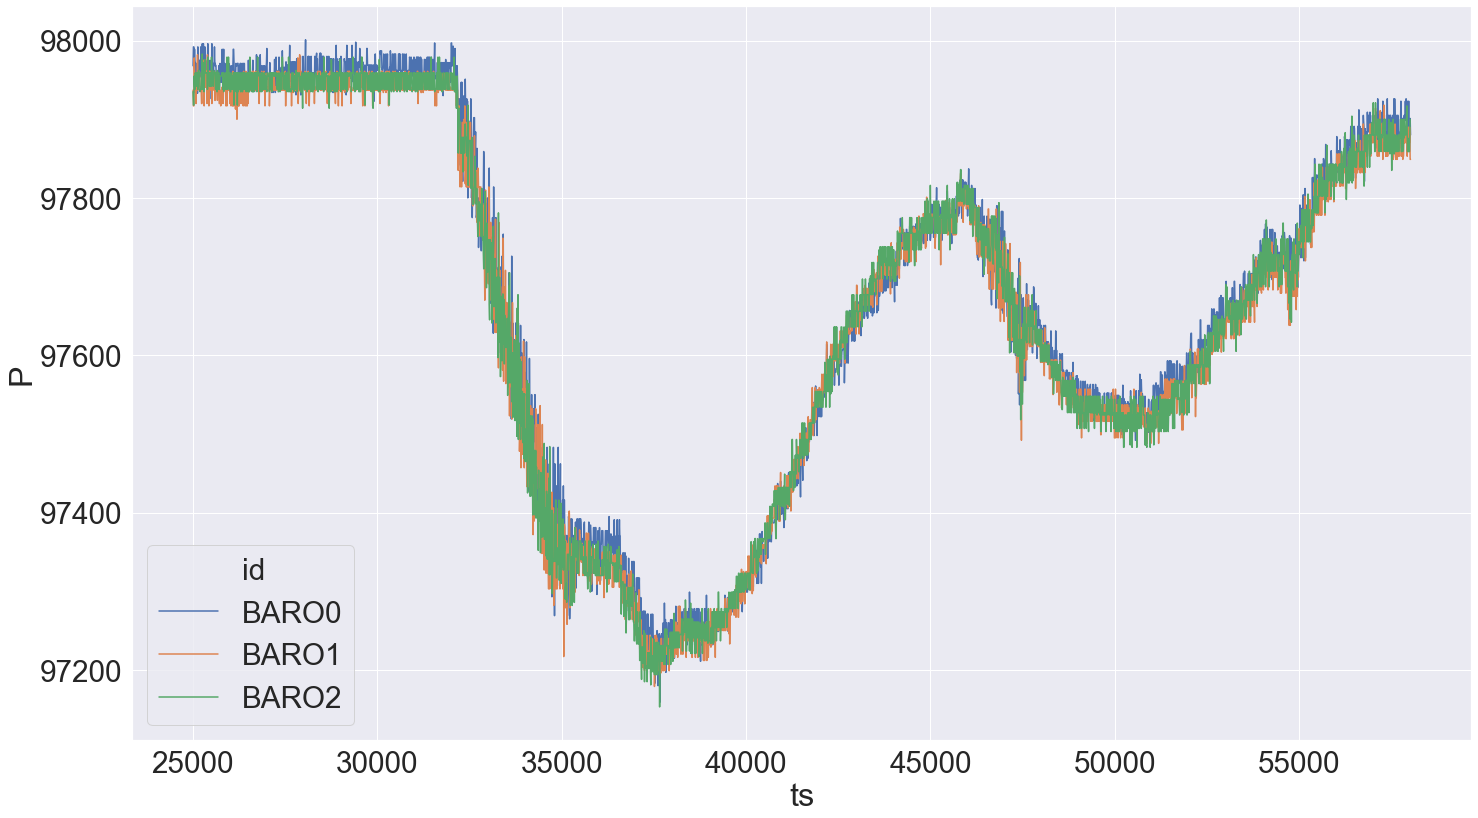

In [26]:
ax = sns.lineplot(data = baro_df, x = 'ts', y = 'P', hue='id')

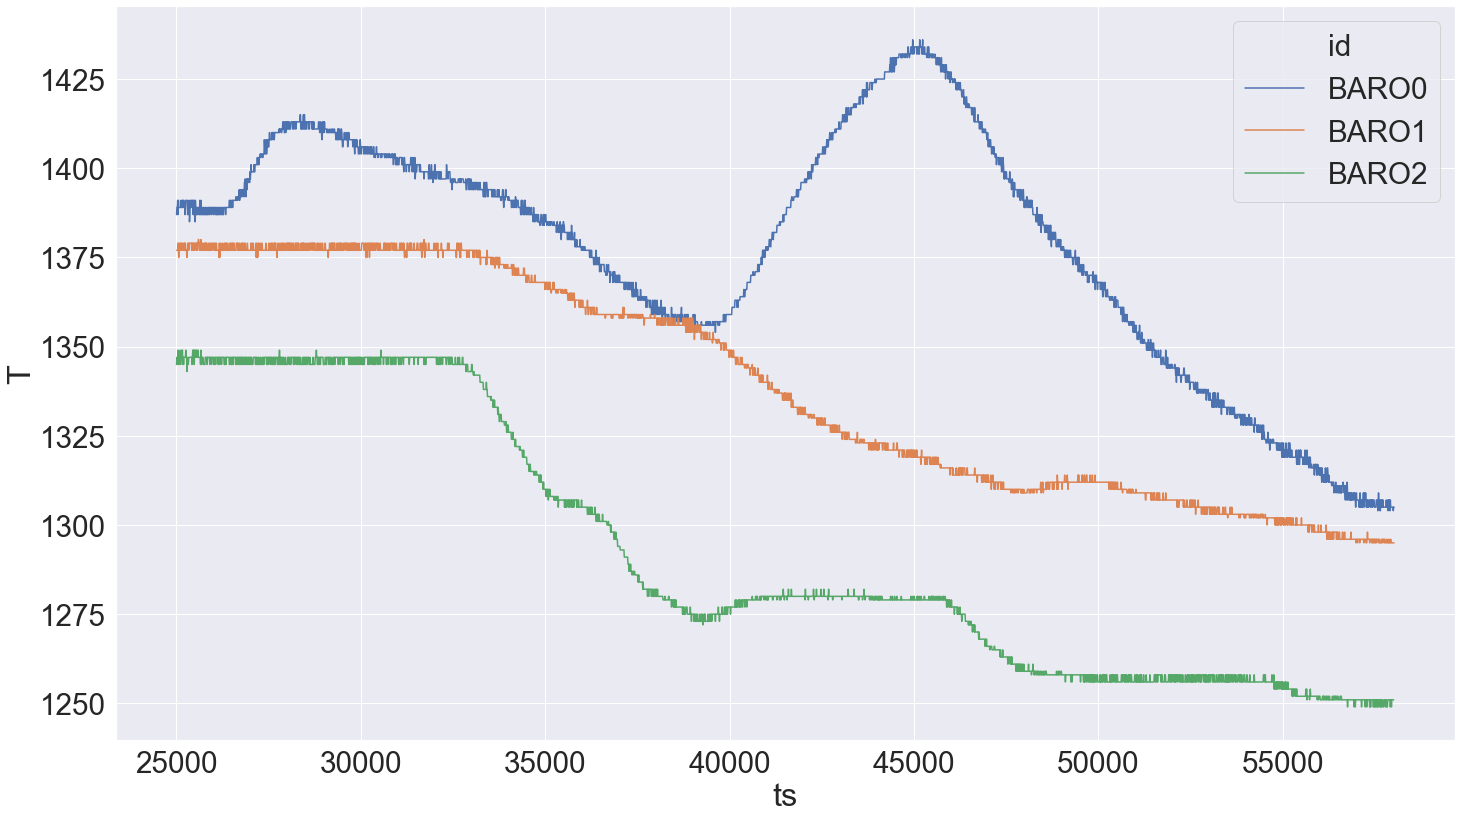

In [27]:
ax = sns.lineplot(data = baro_df, x = 'ts', y = 'T', hue='id')

In [28]:
baro_df

,ts,id,T,P
0,25006,BARO0,1387,97968
1,25006,BARO1,1377,97937
2,25006,BARO2,1345,97935
3,25016,BARO0,1389,97992
4,25016,BARO1,1377,97917
...,...,...,...,...
9900,58006,BARO0,1305,97901
9901,58006,BARO1,1295,97849
9902,58006,BARO2,1251,97900
9903,58016,BARO0,1305,97880


In [29]:
sensor_info_df = pd.DataFrame(sensor_info)

In [30]:
sensor_info_df

,ts,imu_0,imu_1,imu_2,baro_0,baro_1,baro_2
0,25007,0,0,0,0,0,0
1,25017,0,0,0,0,0,0
2,25027,0,0,0,0,0,0
3,25037,0,0,0,0,0,0
4,25047,0,0,0,0,0,0
...,...,...,...,...,...,...,...
3297,57977,0,0,0,0,0,0
3298,57987,0,0,0,0,0,0
3299,57997,0,0,0,0,0,0
3300,58007,0,0,0,0,0,0
